# TGS Salt Identification Challenge

In this notebook we explore the use of pretrained ResNet50 with Keras functional API, and build a image segmentation model for the Kaggle TGS salt Identification competition dataset. 

The following Kaggle kernels have provided great insight during my progress, check out the links below:

Jack (Jiaxin) Shao: https://www.kaggle.com/shaojiaxin/u-net-with-simple-resnet-blocks-v2-new-loss

Bruno G. do Amaral: https://www.kaggle.com/bguberfain/elastic-transform-for-data-augmentation

Peter Hönigschmid: https://www.kaggle.com/phoenigs/u-net-dropout-augmentation-stratification

Juan C EsquivelTGS: https://www.kaggle.com/jcesquiveld/tgs-vanilla-u-net-with-simple-augmentation

NPHard: https://www.kaggle.com/meaninglesslives/apply-crf-unet-resnet

NPHard: https://www.kaggle.com/meaninglesslives/using-resnet50-pretrained-model-in-keras

Jack (Jiaxin) Shao: https://www.kaggle.com/shaojiaxin/u-net-resnet-v3-stratifiedkfold

## Options for improvement to 0.84+

In order to further improve my approach, I plan to do the following:

https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/65226
https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/66643
https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/66568

In [1]:
import numpy as np
import pandas as pd

In [2]:
from random import randint

In [2]:
import gc

In [51]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-white')
#import seaborn as sns
#sns.set_style("white")

In [3]:
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from scipy import ndimage

In [4]:
import cv2
import math

In [5]:
from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
#from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
#from keras.layers import Conv2D, Concatenate, MaxPooling2D
#from keras.layers import UpSampling2D, Dropout, BatchNormalization
from keras.layers import *
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
#from keras.applications.imagenet_utils import _obtain_input_shape
import tensorflow as tf

from keras.applications.vgg16 import VGG16
from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D

Using TensorFlow backend.


In [6]:
cv_total = 5 # stratified 5-fold

version = 8
'''
version1: 9/27/2018 6:21 pm --> successful baseline
version2: 9/29/2018 4:27 pm --> bit of improvement
version3: 9/30/2018 7:05 pm --> worse
version4: 10/02/2018 2:57 pm --> much better CV then v2 but no LB improvement
version5: 10/05/2018 9:53 pm --> scSE resnet50 with weights from v1fold2, lovasz loss
version6: 10/09/2018 11:17am --> scSE resnet50 with Imagenet weights, bce dice loss 0.805
version7: 10/10/2018 3:11 pm --> lovasz loss with v6 checkpoint: 0.775
version8: 10:12:2018 --> uses padding, scSE resnet50 with random weights, bce dice loss
version9: 10/17/2018 11:17am --> scSE resnet50 with Imagenet weights, bce dice loss 0.805
'''
#basic_name_ori = f'Unet_resnet_v{version}'
#save_model_name = basic_name_ori + '.model'
#submission_file = basic_name_ori + '.csv'

'\nversion1: 9/27/2018 6:21 pm --> successful baseline\nversion2: 9/29/2018 4:27 pm --> bit of improvement\nversion3: 9/30/2018 7:05 pm --> worse\nversion4: 10/02/2018 2:57 pm --> much better CV then v2 but no LB improvement\nversion5: 10/05/2018 9:53 pm --> scSE resnet50 with weights from v1fold2, lovasz loss\nversion6: 10/09/2018 11:17am --> scSE resnet50 with Imagenet weights, bce dice loss 0.805\nversion7: 10/10/2018 3:11 pm --> lovasz loss with v6 checkpoint: 0.775\nversion8: 10:12:2018 --> uses padding, scSE resnet50 with random weights, bce dice loss\nversion9: 10/17/2018 11:17am --> scSE resnet50 with Imagenet weights, bce dice loss 0.805\n'

# Params and helpers

In [7]:
img_size_ori = 101
img_size_target = 160#128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    #return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #return np.pad(img, ((13,14),(14,13)), mode = 'reflect')
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[13:img_size_ori, 13:img_size_ori]

# Loading of training/testing ids and depths
Reading in data of the train csv file, which has been filtered to hold no mask images but not small pixel masks.

In [29]:
train_df = pd.read_csv("/Users/JoonH/train_nomask_and_nosmallmask.csv", index_col="id")
#train_df = pd.read_csv("/Users/JoonH/Desktop/TGS_salt_identification/train_original.csv", index_col="id")

# Read images and masks
Load the images and masks into the DataFrame and divide the pixel values by 255.

In [30]:
train_df["images"] = [np.array(load_img("/Users/JoonH/Desktop/TGS_salt_identification/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
C:\Users\JoonH\Anaconda3\lib\site-packages\keras_preprocessing\image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [31]:
train_df["masks"] = [np.array(load_img("/Users/JoonH/Desktop/TGS_salt_identification/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
C:\Users\JoonH\Anaconda3\lib\site-packages\keras_preprocessing\image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


# Calculating the salt coverage and salt coverage classes
Counting the number of salt pixels in the masks and dividing them by the image size. Also create 11 coverage classes, -0.1 having no salt at all to 1.0 being salt only.

In [32]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [33]:
# Labels each image with a class label based on their coverage from 0 to 10, with 0 being no coverage.
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

In [34]:
from sklearn.model_selection import StratifiedKFold
cv_total = 5
train_all = []
evaluate_all = []
skf = StratifiedKFold(n_splits=cv_total, random_state=1234, shuffle=True)
for train_index, evaluate_index in skf.split(train_df.index.values, train_df.coverage_class):
    train_all.append(train_index)
    evaluate_all.append(evaluate_index)
    print(train_index.shape,evaluate_index.shape) # the shape is slightly different in different cv, it's OK

(3120,) (784,)
(3122,) (782,)
(3123,) (781,)
(3124,) (780,)
(3127,) (777,)


In [35]:
def get_cv_data(cv_index):
    train_index = train_all[cv_index-1]
    evaluate_index = evaluate_all[cv_index-1]
    x_train = np.array(train_df.images[train_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    y_train = np.array(train_df.masks[train_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    x_valid = np.array(train_df.images[evaluate_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    y_valid = np.array(train_df.masks[evaluate_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    return x_train,y_train,x_valid,y_valid

# Build model

We will be building a U-net model with ResNet50, with its imagenetweights, as our encoder. Pretrained weights allow us to build a model with an intialization of weights better than that of randomized weights. ResNet50 and ResNet34 has been proven to converge better than vanilla Unet or other models such as VGG19 (this one personally tested), and thus we will be using ResNet50 avaialble in the keras functional API.

In [8]:
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding="same", kernel_initializer="he_normal", strides=strides, name=prefix + "_conv")(prevlayer)
    conv = BatchNormalization(name=prefix + "_bn")(conv)
    conv = Activation('relu', name=prefix + "_activation")(conv)
    return conv

def conv_block_simple_no_bn(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding="same", kernel_initializer="he_normal", strides=strides, name=prefix + "_conv")(prevlayer)
    conv = Activation('relu', name=prefix + "_activation")(conv)
    return conv

def deconv_block_V2(prevlayer, middle, out, prefix1,prefix2, strides=(1, 1)):
    conv = Conv2D(middle, (3, 3), padding='same', kernel_initializer='he_normal', strides=strides)(prevlayer)
    conv = BatchNormalization()(conv)
    conv = Activation('relu', name=prefix1 + "_activation")(conv)
    conv = Conv2D(out, (3, 3), padding='same', kernel_initializer='he_normal', strides=strides)(conv)
    conv = BatchNormalization()(conv)
    conv = Activation('relu', name=prefix2 + "_activation")(conv)
    return conv


In [7]:
K.clear_session()
def get_unet_resnet(input_shape):
    resnet_base = ResNet50(input_shape=input_shape, include_top=False)

    for l in resnet_base.layers:
        l.trainable = True
    conv1 = resnet_base.get_layer("activation_1").output
    conv2 = resnet_base.get_layer("activation_10").output
    conv3 = resnet_base.get_layer("activation_22").output
    conv4 = resnet_base.get_layer("activation_40").output
    conv5 = resnet_base.get_layer("activation_49").output

    up6 = concatenate([UpSampling2D()(conv5), conv4], axis=-1)
    conv6 = conv_block_simple(up6, 128, "conv6_1") #256 -> 128
    conv6 = conv_block_simple(conv6, 128, "conv6_2") #256 -> 128

    up7 = concatenate([UpSampling2D()(conv6), conv3], axis=-1)
    conv7 = conv_block_simple(up7, 96, "conv7_1") #192 -> 96
    conv7 = conv_block_simple(conv7, 96, "conv7_2")

    up8 = concatenate([UpSampling2D()(conv7), conv2], axis=-1)
    conv8 = conv_block_simple(up8, 64, "conv8_1") #128 -> 64
    conv8 = conv_block_simple(conv8, 64, "conv8_2")

    up9 = concatenate([UpSampling2D()(conv8), conv1], axis=-1)
    conv9 = conv_block_simple(up9, 32, "conv9_1") #64 -> 32
    conv9 = conv_block_simple(conv9, 32, "conv9_2")

    up10 = UpSampling2D()(conv9)
    conv10 = conv_block_simple(up10, 16, "conv10_1") #32 -> 16
    conv10 = conv_block_simple(conv10, 16, "conv10_2") #32 -> 16
    conv10 = SpatialDropout2D(0.2)(conv10)
    x = Conv2D(1, (1, 1), activation="sigmoid", name="prediction")(conv10)
    model = Model(resnet_base.input, x)
    return model

In [9]:
K.clear_session()
def get_unet_resnet2(input_shape):
    resnet_base = ResNet50(input_shape=input_shape, include_top=False)

    for l in resnet_base.layers:
        l.trainable = True
    conv1 = resnet_base.get_layer("activation_1").output
    conv2 = resnet_base.get_layer("activation_10").output
    conv3 = resnet_base.get_layer("activation_22").output
    conv4 = resnet_base.get_layer("activation_40").output
    conv5 = resnet_base.get_layer("activation_49").output

    up6 = concatenate([UpSampling2D()(conv5), conv4], axis=-1)
    conv6 = deconv_block_V2(up6, 256,128, "conv6_1","conv6_2") #256 -> 128
    conv6 = csse_block(conv6, 'csse6') #EDIT
    #conv6 = conv_block_custom(conv6, 128, "conv6_2") #256 -> 128

    up7 = concatenate([UpSampling2D()(conv6), conv3], axis=-1)
    conv7 = deconv_block_V2(up7, 192,96, "conv7_1","conv7_2") #192 -> 96
    conv7 = csse_block(conv7, 'csse7') #EDIT
    #conv7 = conv_block_simple(conv7, 96, "conv7_2")

    up8 = concatenate([UpSampling2D()(conv7), conv2], axis=-1)
    conv8 = deconv_block_V2(up8, 128,64, "conv8_1","conv8_2") #128 -> 64
    conv8 = csse_block(conv8, 'csse8') #EDIT
    #conv8 = conv_block_simple(conv8, 64, "conv8_2")

    up9 = concatenate([UpSampling2D()(conv8), conv1], axis=-1)
    conv9 = deconv_block_V2(up9, 64,32, "conv9_1","conv9_2") #64 -> 32
    conv9 = csse_block(conv9, 'csse9') #EDIT
    #conv9 = conv_block_simple(conv9, 32, "conv9_2")

    up10 = UpSampling2D()(conv9)
    conv10 = deconv_block_V2(up10, 32,16, "conv10_1","conv10_2") #32 -> 16
    #conv10 = conv_block_simple(conv10, 16, "conv10_2") #32 -> 16
    conv10 = csse_block(conv10, 'csse10') #EDIT
    conv10 = SpatialDropout2D(0.25)(conv10)
    x = Conv2D(1, (1, 1), activation='sigmoid', name="prediction")(conv10)
    #x = Conv2D(1, (1, 1), activation=None, name="prediction")(conv10) #for lovasz loss
    model = Model(resnet_base.input, x)
    return model

In [10]:
import warnings

#from keras.applications.imagenet_utils import _obtain_input_shape
from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file

WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'


def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'keras.., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'keras.., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3, the first conv layer at main path is with strides=(2,2)
    And the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

#=================================================================================================
#https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/66178
def cse_block(prevlayer, prefix):
    mean = Lambda(lambda xin: K.mean(xin, axis=[1, 2]))(prevlayer)
    lin1 = Dense(K.int_shape(prevlayer)[3]//2, name=prefix + 'cse_lin1', activation='relu')(mean)
    lin2 = Dense(K.int_shape(prevlayer)[3], name=prefix + 'cse_lin2', activation='sigmoid')(lin1)
    x = Multiply()([prevlayer, lin2])
    return x

def sse_block(prevlayer, prefix):
    conv = Conv2D(1, (1, 1), padding="same", kernel_initializer="he_normal", activation='sigmoid', strides=(1, 1),
                  name=prefix + "_conv")(prevlayer)
    conv = Multiply(name=prefix + "_mul")([prevlayer, conv])
    return conv

def csse_block(x, prefix):
    '''
    Implementation of Concurrent Spatial and Channel ‘Squeeze & Excitation’ in Fully Convolutional Networks
    https://arxiv.org/abs/1803.02579
    '''
    cse = cse_block(x, prefix)
    sse = sse_block(x, prefix)
    x = Add(name=prefix + "_csse_mul")([cse, sse])

    return x

In [11]:
def ResNet50(include_top=True, weights='imagenet',
             input_tensor=None, input_shape=None,
             pooling=None,
             classes=1000):
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv1')(img_input)
    x = csse_block(x, 'csse1') #EDIT
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = csse_block(x, 'csse2') #EDIT
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = csse_block(x, 'csse3') #EDIT
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = csse_block(x, 'csse4') #EDIT
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = csse_block(x, 'csse5') #EDIT
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

#     x = AveragePooling2D((7, 7), name='avg_pool')(x)

#     if include_top:
#         x = Flatten()(x)
#         x = Dense(classes, activation='softmax', name='fc1000')(x)
#     else:
#         if pooling == 'avg':
#             x = GlobalAveragePooling2D()(x)
#         elif pooling == 'max':
#             x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnet50')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models',
                                    md5_hash='a7b3fe01876f51b976af0dea6bc144eb')
        else:
            weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models',
                                    md5_hash='a268eb855778b3df3c7506639542a6af')
        model.load_weights(weights_path,by_name=True)
    return model

In [12]:
def relu6(x):
    return K.relu(x, max_value=6)

# Metric - a good, single metric to optimize goes a long way down the project.

A good metric is what one should have for a thorough, or good enough understanding of how well the model is performing. Since this competition is based on Intersection over Union, or IoU, where the metric is calculated by the intersection of the prediction and ground truth divided by the sum of prediction and ground truth pixels, it is a good idea to use this as our metric to optimize and thus evaluate our model with. We have two similar metrics that both utilize IoU, and I fiddle around both of them.

In [13]:
# Fast IoU metric
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

#===============================================================================================================================

def castF(x):
    return K.cast(x, K.floatx())

def castB(x):
    return K.cast(x, bool)

def iou_loss_core(true,pred):
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

def competitionMetric2(true, pred): #any shape can go

    tresholds = [0.5 + (i*.05)  for i in range(10)]

    #flattened images (batch, pixels)
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = castF(K.greater(pred, 0.5))

    #total white pixels - (batch,)
    trueSum = K.sum(true, axis=-1)
    predSum = K.sum(pred, axis=-1)

    #has mask or not per image - (batch,)
    true1 = castF(K.greater(trueSum, 1))    
    pred1 = castF(K.greater(predSum, 1))

    #to get images that have mask in both true and pred
    truePositiveMask = castB(true1 * pred1)

    #separating only the possible true positives to check iou
    testTrue = tf.boolean_mask(true, truePositiveMask)
    testPred = tf.boolean_mask(pred, truePositiveMask)

    #getting iou and threshold comparisons
    iou = iou_loss_core(testTrue,testPred) 
    truePositives = [castF(K.greater(iou, tres)) for tres in tresholds]

    #mean of thressholds for true positives and total sum
    truePositives = K.mean(K.stack(truePositives, axis=-1), axis=-1)
    truePositives = K.sum(truePositives)

    #to get images that don't have mask in both true and pred
    trueNegatives = (1-true1) * (1 - pred1) # = 1 -true1 - pred1 + true1*pred1
    trueNegatives = K.sum(trueNegatives) 

    return (truePositives + trueNegatives) / castF(K.shape(true)[0])

# Loss functions - some tuning should take place

A good loss function is crucial to building a high performing model. In this case the model is first trained with bce_dice_loss and then further finetuned with lovasz. 

In [14]:
from keras.losses import binary_crossentropy
from keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss


In [13]:

#=========================================================================================================
"""
Lovasz-Softmax and Jaccard hinge loss in Tensorflow
Maxim Berman 2018 ESAT-PSI KU Leuven (MIT License)
"""

from __future__ import print_function, division

import tensorflow as tf
import numpy as np

def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# =================================== BINARY LOSSES ===================================


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels


# =================================== MULTICLASS LOSSES ===================================


def lovasz_softmax(probas, labels, classes='all', per_image=False, ignore=None, order='BHWC'):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, H, W, C] or [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
      order: use BHWC or BCHW
    """
    if per_image:
        def treat_image(prob_lab):
            prob, lab = prob_lab
            prob, lab = tf.expand_dims(prob, 0), tf.expand_dims(lab, 0)
            prob, lab = flatten_probas(prob, lab, ignore, order)
            return lovasz_softmax_flat(prob, lab, classes=classes)
        losses = tf.map_fn(treat_image, (probas, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_softmax_flat(*flatten_probas(probas, labels, ignore, order), classes=classes)
    return loss


def lovasz_softmax_flat(probas, labels, classes='all'):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
    """
    C = 1
    losses = []
    present = []
    class_to_sum = list(range(C)) if classes in ['all', 'present'] else classes
    for c in class_to_sum:
        fg = tf.cast(tf.equal(labels, c), probas.dtype)  # foreground for class c
        if classes == 'present':
            present.append(tf.reduce_sum(fg) > 0)
        errors = tf.abs(fg - probas[:, c])
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort_{}".format(c))
        fg_sorted = tf.gather(fg, perm)
        grad = lovasz_grad(fg_sorted)
        losses.append(
            tf.tensordot(errors_sorted, tf.stop_gradient(grad), 1, name="loss_class_{}".format(c))
                      )
    if len(class_to_sum) == 1:  # short-circuit mean when only one class
        return losses[0]
    losses_tensor = tf.stack(losses)
    if classes == 'present':
        present = tf.stack(present)
        losses_tensor = tf.boolean_mask(losses_tensor, present)
    loss = tf.reduce_mean(losses_tensor)
    return loss


def flatten_probas(probas, labels, ignore=None, order='BHWC'):
    """
    Flattens predictions in the batch
    """
    if order == 'BCHW':
        probas = tf.transpose(probas, (0, 2, 3, 1), name="BCHW_to_BHWC")
        order = 'BHWC'
    if order != 'BHWC':
        raise NotImplementedError('Order {} unknown'.format(order))
    C = 1
    probas = tf.reshape(probas, (-1, C))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return probas, labels
    valid = tf.not_equal(labels, ignore)
    vprobas = tf.boolean_mask(probas, valid, name='valid_probas')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vprobas, vlabels

def keras_lovasz_softmax(labels,probas):
    #return lovasz_softmax(probas, labels)+binary_crossentropy(labels, probas)
    return lovasz_softmax(probas, labels)

def keras_lovasz_hinge(labels,logits):
    return lovasz_hinge(logits, labels, per_image=True, ignore=None)

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

#===================================focal_loss===================================

def focal_loss(y_true, y_pred):
    gamma=0.5
    alpha=0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

In [14]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

In [15]:
import gc
gc.enable()

In [16]:
from keras.optimizers import Adam,SGD

def build_complie_model(lr = 0.005):
    K.clear_session()
    input_layer = Input((img_size_target, img_size_target, 3))
    model = get_unet_resnet2(input_shape=(img_size_target,img_size_target,3))
    #model = get_unet_resnet(input_shape=(img_size_target,img_size_target,3))

    c = SGD(lr = lr) #SGD(lr = lr)
    model.compile(loss=bce_dice_loss, optimizer='adam', metrics=[competitionMetric2, my_iou_metric]) #for random initialization
    #model.compile(loss=lovasz_loss, optimizer=c, metrics=[competitionMetric2,my_iou_metric_2]) #for checkpoint weights
    return model

def load_compile_model(fold):
    import keras
    K.clear_session()
    input_layer = Input((img_size_target, img_size_target, 3))
    load_name = 'Unet_resnet50_v1_fold' + str(fold+1) + '.model'
    model = load_model(load_name, custom_objects = {'bce_dice_loss' : bce_dice_loss, 
                                                    'competitionMetric2' : competitionMetric2,
                                                    'my_iou_metric' : my_iou_metric})
    c = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss=bce_dice_loss, optimizer=c, metrics=[competitionMetric2, my_iou_metric])
    return model

In [17]:
def plot_history(history,metric_name):
    fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_score.plot(history.epoch, history.history[metric_name], label="Train score")
    ax_score.plot(history.epoch, history.history["val_" + metric_name], label="Validation score")
    ax_score.legend()

def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect, batch_size = 16).reshape(-1, img_size_target, img_size_target)
    # batch size changed to 30 from default 32.
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

In [30]:
#basic_name = f"Unet_resnet_v{version}_cv{cv_index+1}"

In [31]:
import keras
def cosine_annealing(x):
    lr = 0.005
    epochs = 60
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)
    

scheduler = keras.callbacks.LearningRateScheduler(cosine_annealing, verbose=0)

############################################
 Unet_resnet50_v8_fold1


C:\Users\JoonH\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Train on 6240 samples, validate on 784 samples
Epoch 1/60
 - 189s - loss: 0.7518 - competitionMetric2: 0.4814 - my_iou_metric: 0.4795 - val_loss: 1.7619 - val_competitionMetric2: 0.3864 - val_my_iou_metric: 0.3870

Epoch 00001: val_competitionMetric2 improved from -inf to 0.38635, saving model to Unet_resnet50_v8_fold1.model
Epoch 2/60
 - 171s - loss: 0.4983 - competitionMetric2: 0.6223 - my_iou_metric: 0.6225 - val_loss: 1.6377 - val_competitionMetric2: 0.4557 - val_my_iou_metric: 0.4541

Epoch 00002: val_competitionMetric2 improved from 0.38635 to 0.45574, saving model to Unet_resnet50_v8_fold1.model
Epoch 3/60
 - 170s - loss: 0.4352 - competitionMetric2: 0.6658 - my_iou_metric: 0.6664 - val_loss: 1.9187 - val_competitionMetric2: 0.4554 - val_my_iou_metric: 0.4531

Epoch 00003: val_competitionMetric2 did not improve from 0.45574
Epoch 4/60
 - 170s - loss: 0.4094 - competitionMetric2: 0.6930 - my_iou_metric: 0.6926 - val_loss: 0.9074 - val_competitionMetric2: 0.6041 - val_my_iou_metri


Epoch 00032: val_competitionMetric2 did not improve from 0.77500
Epoch 33/60
 - 171s - loss: 0.0939 - competitionMetric2: 0.8630 - my_iou_metric: 0.8637 - val_loss: 0.7290 - val_competitionMetric2: 0.7448 - val_my_iou_metric: 0.7471

Epoch 00033: val_competitionMetric2 did not improve from 0.77500
Epoch 34/60
 - 171s - loss: 0.0929 - competitionMetric2: 0.8662 - my_iou_metric: 0.8671 - val_loss: 0.7846 - val_competitionMetric2: 0.7406 - val_my_iou_metric: 0.7385

Epoch 00034: val_competitionMetric2 did not improve from 0.77500
Epoch 35/60
 - 171s - loss: 0.0957 - competitionMetric2: 0.8651 - my_iou_metric: 0.8657 - val_loss: 0.7126 - val_competitionMetric2: 0.7599 - val_my_iou_metric: 0.7614

Epoch 00035: val_competitionMetric2 did not improve from 0.77500
Epoch 36/60
 - 171s - loss: 0.0906 - competitionMetric2: 0.8696 - my_iou_metric: 0.8696 - val_loss: 0.7323 - val_competitionMetric2: 0.7658 - val_my_iou_metric: 0.7622

Epoch 00036: val_competitionMetric2 did not improve from 0.7750


Epoch 00006: val_competitionMetric2 did not improve from 0.65460
Epoch 7/60
 - 171s - loss: 0.3489 - competitionMetric2: 0.7154 - my_iou_metric: 0.7165 - val_loss: 0.7655 - val_competitionMetric2: 0.7308 - val_my_iou_metric: 0.7274

Epoch 00007: val_competitionMetric2 improved from 0.65460 to 0.73082, saving model to Unet_resnet50_v8_fold2.model
Epoch 8/60
 - 171s - loss: 0.3504 - competitionMetric2: 0.7157 - my_iou_metric: 0.7163 - val_loss: 3.3388 - val_competitionMetric2: 0.3811 - val_my_iou_metric: 0.3793

Epoch 00008: val_competitionMetric2 did not improve from 0.73082
Epoch 9/60
 - 171s - loss: 0.3194 - competitionMetric2: 0.7297 - my_iou_metric: 0.7304 - val_loss: 1.3326 - val_competitionMetric2: 0.4661 - val_my_iou_metric: 0.4628

Epoch 00009: val_competitionMetric2 did not improve from 0.73082
Epoch 10/60
 - 171s - loss: 0.3115 - competitionMetric2: 0.7365 - my_iou_metric: 0.7368 - val_loss: 1.2217 - val_competitionMetric2: 0.5087 - val_my_iou_metric: 0.5072

Epoch 00010: val

Epoch 00038: val_competitionMetric2 did not improve from 0.80614
Epoch 39/60
 - 171s - loss: 0.0814 - competitionMetric2: 0.8713 - my_iou_metric: 0.8718 - val_loss: 0.6715 - val_competitionMetric2: 0.7749 - val_my_iou_metric: 0.7726

Epoch 00039: val_competitionMetric2 did not improve from 0.80614
Epoch 40/60
 - 171s - loss: 0.0825 - competitionMetric2: 0.8681 - my_iou_metric: 0.8694 - val_loss: 0.6666 - val_competitionMetric2: 0.7919 - val_my_iou_metric: 0.7913

Epoch 00040: val_competitionMetric2 did not improve from 0.80614
Epoch 41/60
 - 171s - loss: 0.0795 - competitionMetric2: 0.8691 - my_iou_metric: 0.8697 - val_loss: 0.6725 - val_competitionMetric2: 0.7919 - val_my_iou_metric: 0.7880

Epoch 00041: val_competitionMetric2 did not improve from 0.80614
Epoch 42/60
 - 171s - loss: 0.0756 - competitionMetric2: 0.8732 - my_iou_metric: 0.8738 - val_loss: 0.6581 - val_competitionMetric2: 0.7881 - val_my_iou_metric: 0.7867

Epoch 00042: val_competitionMetric2 did not improve from 0.80614

Epoch 12/60
 - 171s - loss: 0.3201 - competitionMetric2: 0.7429 - my_iou_metric: 0.7442 - val_loss: 0.7713 - val_competitionMetric2: 0.7380 - val_my_iou_metric: 0.7379

Epoch 00012: val_competitionMetric2 improved from 0.71754 to 0.73803, saving model to Unet_resnet50_v8_fold3.model
Epoch 13/60
 - 171s - loss: 0.3163 - competitionMetric2: 0.7464 - my_iou_metric: 0.7470 - val_loss: 1.5314 - val_competitionMetric2: 0.4512 - val_my_iou_metric: 0.4494

Epoch 00013: val_competitionMetric2 did not improve from 0.73803
Epoch 14/60
 - 171s - loss: 0.2930 - competitionMetric2: 0.7514 - my_iou_metric: 0.7525 - val_loss: 0.8732 - val_competitionMetric2: 0.6794 - val_my_iou_metric: 0.6771

Epoch 00014: val_competitionMetric2 did not improve from 0.73803
Epoch 15/60
 - 171s - loss: 0.2720 - competitionMetric2: 0.7629 - my_iou_metric: 0.7641 - val_loss: 0.8382 - val_competitionMetric2: 0.5827 - val_my_iou_metric: 0.5905

Epoch 00015: val_competitionMetric2 did not improve from 0.73803
Epoch 16/60
 -


Epoch 00044: val_competitionMetric2 did not improve from 0.81831
Epoch 45/60
 - 171s - loss: 0.0875 - competitionMetric2: 0.8658 - my_iou_metric: 0.8669 - val_loss: 0.6420 - val_competitionMetric2: 0.8029 - val_my_iou_metric: 0.8044

Epoch 00045: val_competitionMetric2 did not improve from 0.81831
Epoch 46/60
 - 171s - loss: 0.0856 - competitionMetric2: 0.8707 - my_iou_metric: 0.8703 - val_loss: 0.6385 - val_competitionMetric2: 0.8132 - val_my_iou_metric: 0.8095

Epoch 00046: val_competitionMetric2 did not improve from 0.81831
Epoch 47/60
 - 171s - loss: 0.0846 - competitionMetric2: 0.8707 - my_iou_metric: 0.8713 - val_loss: 0.6613 - val_competitionMetric2: 0.8022 - val_my_iou_metric: 0.7988

Epoch 00047: val_competitionMetric2 did not improve from 0.81831
Epoch 48/60
 - 171s - loss: 0.0818 - competitionMetric2: 0.8703 - my_iou_metric: 0.8709 - val_loss: 0.6969 - val_competitionMetric2: 0.7428 - val_my_iou_metric: 0.7391

Epoch 00048: val_competitionMetric2 did not improve from 0.8183


Epoch 00017: val_competitionMetric2 did not improve from 0.75295
Epoch 18/60
 - 171s - loss: 0.2040 - competitionMetric2: 0.7931 - my_iou_metric: 0.7941 - val_loss: 0.5967 - val_competitionMetric2: 0.7895 - val_my_iou_metric: 0.7887

Epoch 00018: val_competitionMetric2 improved from 0.75295 to 0.78949, saving model to Unet_resnet50_v8_fold4.model
Epoch 19/60
 - 171s - loss: 0.2077 - competitionMetric2: 0.7927 - my_iou_metric: 0.7928 - val_loss: 0.9624 - val_competitionMetric2: 0.6154 - val_my_iou_metric: 0.6168

Epoch 00019: val_competitionMetric2 did not improve from 0.78949
Epoch 20/60
 - 171s - loss: 0.2034 - competitionMetric2: 0.7971 - my_iou_metric: 0.7982 - val_loss: 0.8106 - val_competitionMetric2: 0.7167 - val_my_iou_metric: 0.7169

Epoch 00020: val_competitionMetric2 did not improve from 0.78949
Epoch 21/60
 - 171s - loss: 0.1910 - competitionMetric2: 0.7962 - my_iou_metric: 0.7964 - val_loss: 0.6480 - val_competitionMetric2: 0.7836 - val_my_iou_metric: 0.7835

Epoch 00021: 

Epoch 00050: val_competitionMetric2 did not improve from 0.80846
Epoch 51/60
 - 171s - loss: 0.0769 - competitionMetric2: 0.8749 - my_iou_metric: 0.8747 - val_loss: 0.6104 - val_competitionMetric2: 0.7888 - val_my_iou_metric: 0.7894

Epoch 00051: val_competitionMetric2 did not improve from 0.80846
Epoch 52/60
 - 171s - loss: 0.0794 - competitionMetric2: 0.8706 - my_iou_metric: 0.8710 - val_loss: 0.6238 - val_competitionMetric2: 0.8003 - val_my_iou_metric: 0.7973

Epoch 00052: val_competitionMetric2 did not improve from 0.80846
Epoch 53/60
 - 171s - loss: 0.0799 - competitionMetric2: 0.8727 - my_iou_metric: 0.8736 - val_loss: 0.6279 - val_competitionMetric2: 0.8017 - val_my_iou_metric: 0.7978

Epoch 00053: val_competitionMetric2 did not improve from 0.80846
Epoch 54/60
 - 171s - loss: 0.0775 - competitionMetric2: 0.8719 - my_iou_metric: 0.8725 - val_loss: 0.6227 - val_competitionMetric2: 0.7947 - val_my_iou_metric: 0.7960

Epoch 00054: val_competitionMetric2 did not improve from 0.80846

Epoch 23/60
 - 171s - loss: 0.1440 - competitionMetric2: 0.8279 - my_iou_metric: 0.8286 - val_loss: 1.5048 - val_competitionMetric2: 0.5486 - val_my_iou_metric: 0.5486

Epoch 00023: val_competitionMetric2 did not improve from 0.76486

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 24/60
 - 171s - loss: 0.1370 - competitionMetric2: 0.8323 - my_iou_metric: 0.8329 - val_loss: 0.6142 - val_competitionMetric2: 0.7869 - val_my_iou_metric: 0.7883

Epoch 00024: val_competitionMetric2 improved from 0.76486 to 0.78687, saving model to Unet_resnet50_v8_fold5.model
Epoch 25/60
 - 171s - loss: 0.1235 - competitionMetric2: 0.8469 - my_iou_metric: 0.8476 - val_loss: 0.6129 - val_competitionMetric2: 0.7921 - val_my_iou_metric: 0.7920

Epoch 00025: val_competitionMetric2 improved from 0.78687 to 0.79215, saving model to Unet_resnet50_v8_fold5.model
Epoch 26/60
 - 171s - loss: 0.1151 - competitionMetric2: 0.8479 - my_iou_metric: 0.8491 - val_loss: 0.6183 - val_comp


Epoch 00056: val_competitionMetric2 did not improve from 0.80116
Epoch 57/60
 - 171s - loss: 0.0603 - competitionMetric2: 0.8958 - my_iou_metric: 0.8962 - val_loss: 0.7098 - val_competitionMetric2: 0.7459 - val_my_iou_metric: 0.7516

Epoch 00057: val_competitionMetric2 did not improve from 0.80116
Epoch 58/60
 - 171s - loss: 0.0544 - competitionMetric2: 0.9023 - my_iou_metric: 0.9026 - val_loss: 0.6995 - val_competitionMetric2: 0.7786 - val_my_iou_metric: 0.7803

Epoch 00058: val_competitionMetric2 did not improve from 0.80116
Epoch 59/60
 - 171s - loss: 0.0542 - competitionMetric2: 0.9055 - my_iou_metric: 0.9057 - val_loss: 0.6713 - val_competitionMetric2: 0.7802 - val_my_iou_metric: 0.7799

Epoch 00059: val_competitionMetric2 did not improve from 0.80116
Epoch 60/60
 - 171s - loss: 0.0524 - competitionMetric2: 0.9103 - my_iou_metric: 0.9107 - val_loss: 0.6896 - val_competitionMetric2: 0.7757 - val_my_iou_metric: 0.7788

Epoch 00060: val_competitionMetric2 did not improve from 0.8011

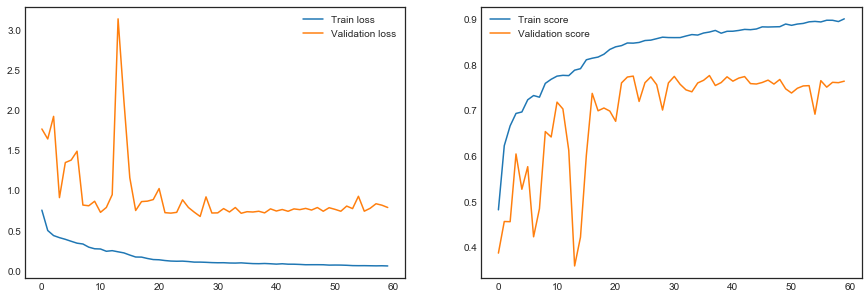

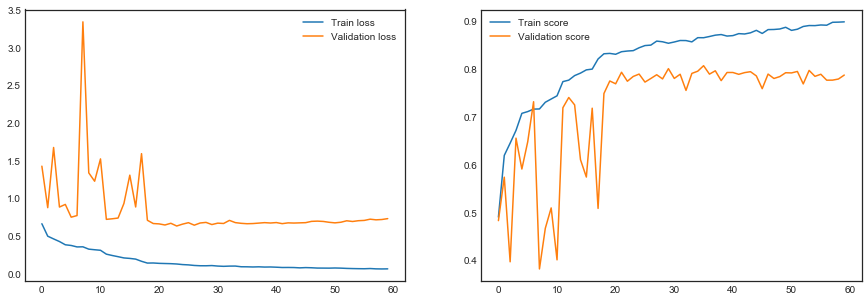

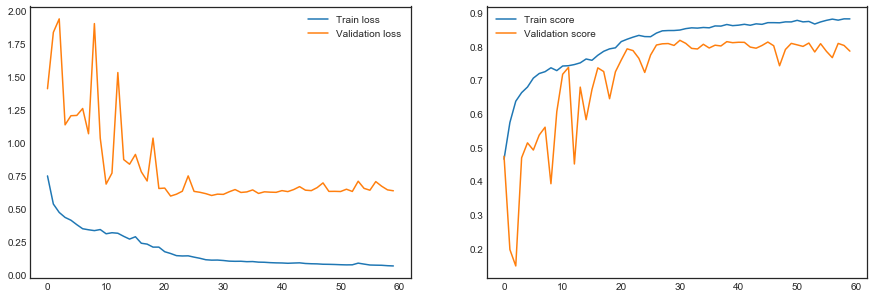

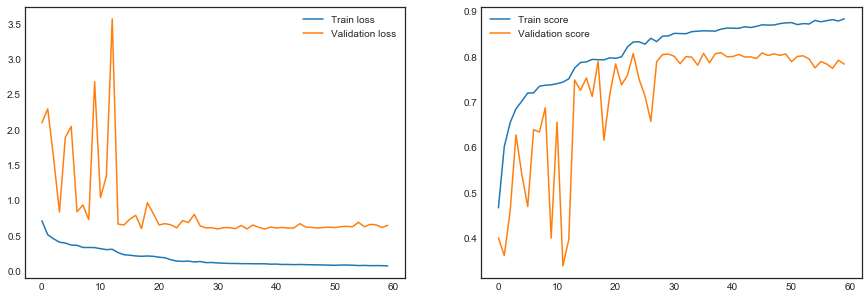

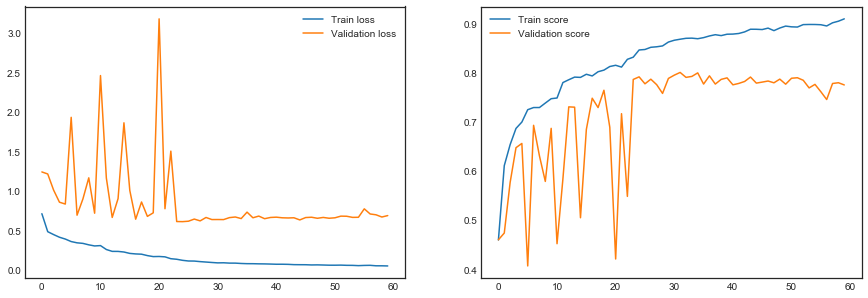

In [52]:
# training
ious = [0] * cv_total
for cv_index in range(cv_total):
    basic_name = 'Unet_resnet50_v' + str(version) + '_fold' + str(cv_index+1)
    
    #f"Unet_resnet_v{version}_cv{cv_index+1}"
    print('############################################\n', basic_name)
    save_model_name = basic_name + '.model'
    
    x_train, y_train, x_valid, y_valid =  get_cv_data(cv_index+1)
    
    #Data augmentation    
    x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
    y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
    
    x_train = np.repeat(x_train,3,axis=3)
    x_valid = np.repeat(x_valid,3,axis=3)

    model = build_complie_model()
    #edit_loading best checkpoint for each fold, loading from v1 since they performed best
    #name = 'Unet_resnet50_v1_fold' + str(cv_index + 1)
    #model.load_model(name)
    #load_model_name = 'Unet_resnet50_v6_fold2.model'
    #model.load_weights(load_model_name,by_name=True)
    
    model_checkpoint = ModelCheckpoint(save_model_name,monitor= 'val_competitionMetric2', #val_my_iou_metric_2
                                   mode = 'max', save_best_only=True, verbose=1,save_weights_only = True)
    reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode = 'max',
                                  factor=0.5, patience=4, min_lr=0.0001, verbose=1)

    epochs = 60
    batch_size = 16
    history = model.fit(x_train, y_train,
                        validation_data=[x_valid, y_valid], 
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[model_checkpoint,reduce_lr],  #scheduler 
                        verbose=2)
    #plot_history(history,'my_iou_metric')
    plot_history(history,'competitionMetric2')
    model.load_weights(save_model_name)
    preds_valid = predict_result(model,x_valid,img_size_target)
    ious[cv_index] = get_iou_vector(y_valid, (preds_valid > 0.5)) #0


In [47]:
for cv_index in range(cv_total):
    print(ious[cv_index])

0
0
0
0
0


In [18]:
train_df = pd.read_csv("/Users/JoonH/Desktop/TGS_salt_identification/train_original.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("/Users/JoonH/Desktop/TGS_salt_identification/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]
del train_df, depths_df

In [19]:
x_test = np.array([upsample(np.array(load_img("/Users/JoonH/Desktop/TGS_salt_identification/test/images/{}.png".format(idx), color_mode = "grayscale"))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)
x_test = np.repeat(x_test,3,axis=3)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
C:\Users\JoonH\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [20]:
gc.collect()

0

In [21]:
#version = 4 # to try changing threhold for first version

for cv_index in range(cv_total):
    basic_name = 'Unet_resnet50_v' + str(version) + '_fold' + str(cv_index+1)
    model = build_complie_model(lr = 0.01)
    model.load_weights(basic_name + '.model')
    print('model loaded!')
    preds_test_temp = predict_result(model,x_test,img_size_target)
    print('prediction made!')
    if cv_index==0:
        preds_test = preds_test_temp
    else:
        preds_test += preds_test_temp
    del model
    gc.collect()
preds_test = preds_test / cv_total
    
    #preds_test += predict_result(model,x_test,img_size_target) /cv_total

model loaded!
prediction made!
model loaded!
prediction made!
model loaded!
prediction made!
model loaded!
prediction made!
model loaded!
prediction made!


In [22]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [23]:
threshold  = 0.5 # some value in range 0.4- 0.5 may be better 
#pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > threshold)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i])) > threshold) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
C:\Users\JoonH\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [24]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub_name = 'tgs_submissionv' + str(version) + '.csv'
sub.to_csv(sub_name)

# Apply Crf

In [28]:
import numpy as np
import pydensecrf.densecrf as dcrf
from skimage.io import imread, imsave
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
%matplotlib inline

In [29]:
def rle_decode(rle_mask):
    '''
    rle_mask: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = rle_mask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(101*101, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(101,101)

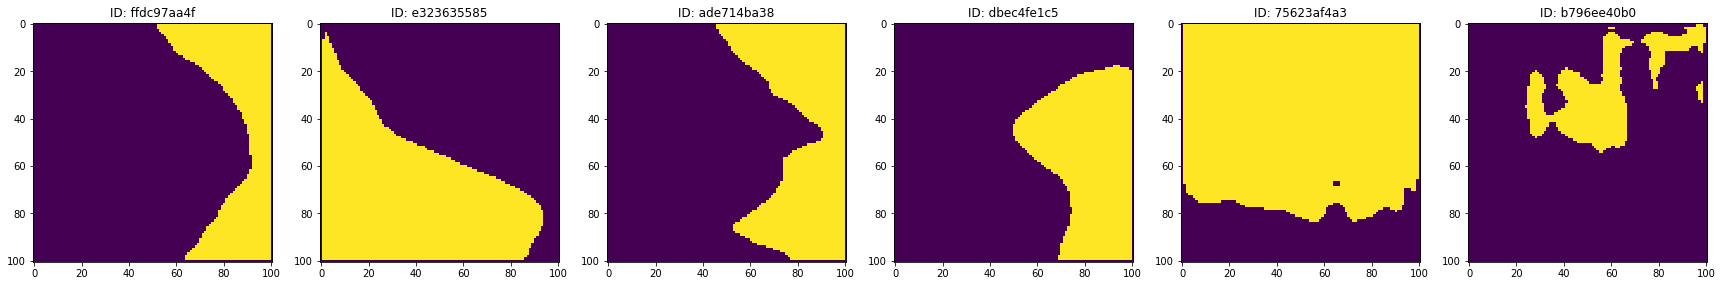

In [30]:
"""
reading and decoding the submission 

"""
df = pd.read_csv('/Users/JoonH/tgs_submissionv5.csv')
i = 0
j = 0
plt.figure(figsize=(30,15))
plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0.2)  #adjust this to change vertical and horiz. spacings..
# Visualizing the predicted outputs
while True:
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
        decoded_mask = rle_decode(df.loc[i,'rle_mask'])
        plt.subplot(1,6,j+1)
        plt.imshow(decoded_mask)
        plt.title('ID: '+df.loc[i,'id'])
        j = j + 1
        if j>5:
            break
    i = i + 1

In [31]:
#Original_image = Image which has to labelled
#Mask image = Which has been labelled by some technique..
def crf(original_image, mask_img):
    
    # Converting annotated image to RGB if it is Gray scale
    if(len(mask_img.shape)<3):
        mask_img = gray2rgb(mask_img)

#     #Converting the annotations RGB color to single 32 bit integer
    annotated_label = mask_img[:,:,0] + (mask_img[:,:,1]<<8) + (mask_img[:,:,2]<<16)
    
#     # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)

    n_labels = 2
    
    #Setting up the CRF model
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    #Run Inference for 10 steps 
    Q = d.inference(10)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))

In [32]:
test_path = '/Users/JoonH/Desktop/TGS_salt_identification/test/images/'

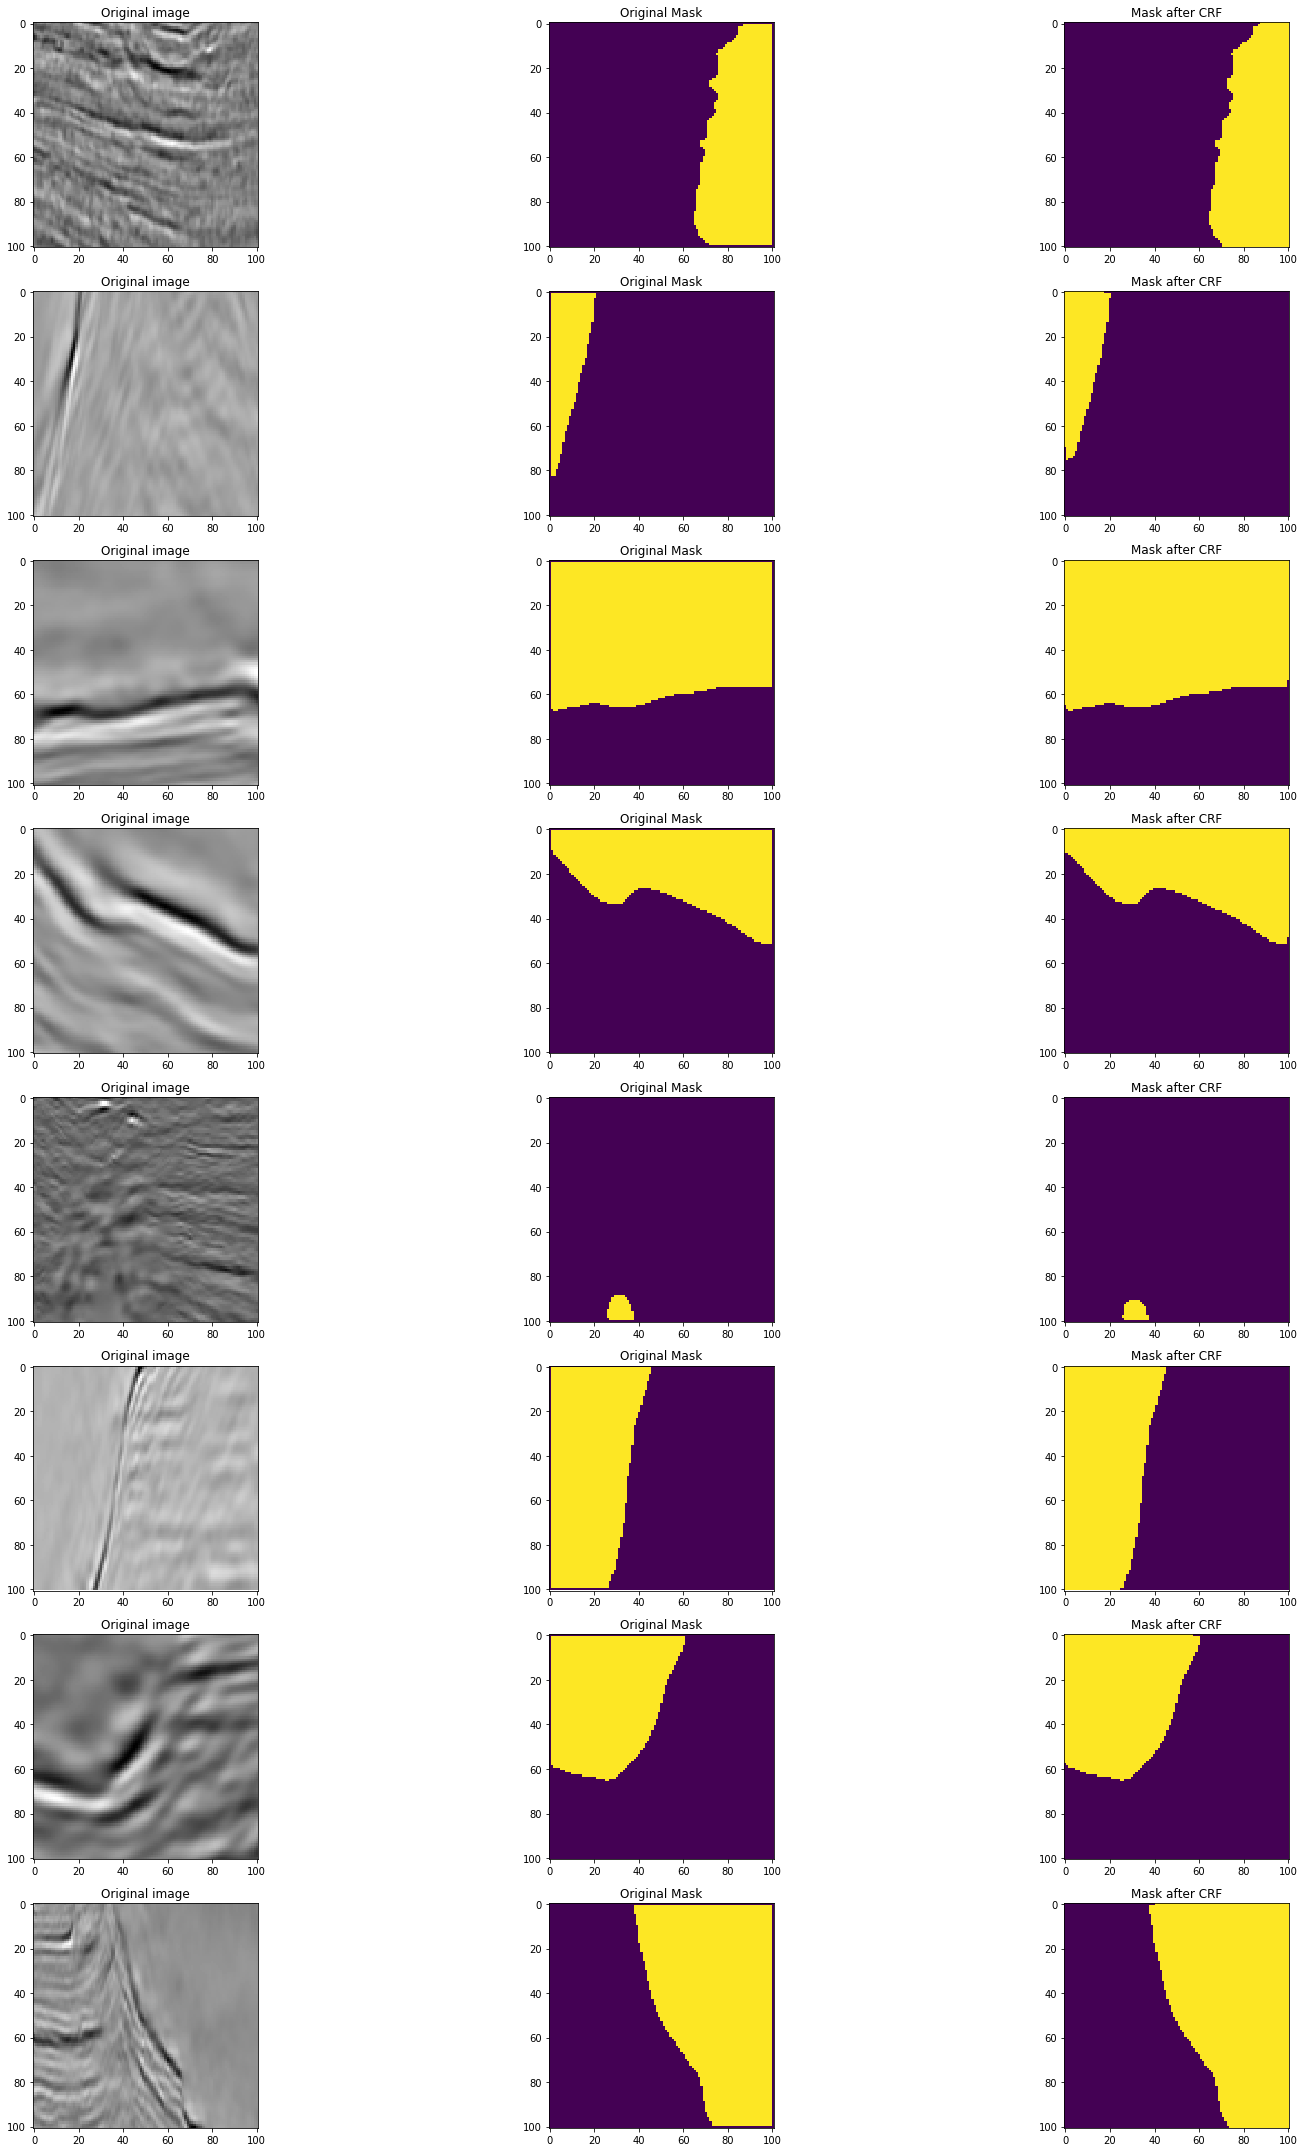

In [33]:
"""
visualizing the effect of applying CRF

"""
np.random.seed(100)
nImgs = 8
i = np.random.randint(1000)
j = 1
plt.figure(figsize=(30,30))
while True:
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
        decoded_mask = rle_decode(df.loc[i,'rle_mask'])        
        orig_img = imread(test_path+df.loc[i,'id']+'.png')
        #Applying CRF on FCN-16 annotated image
        crf_output = crf(orig_img,decoded_mask)
        plt.subplot(nImgs,4,4*j-3)
        plt.imshow(orig_img)
        plt.title('Original image')
        plt.subplot(nImgs,4,4*j-2)
        plt.imshow(np.fliplr(np.rot90(decoded_mask,k=3)))
        plt.title('Original Mask')
        plt.subplot(nImgs,4,4*j-1)
        plt.imshow(np.fliplr(np.rot90(crf_output,k=3)))
        plt.title('Mask after CRF')
        if j == nImgs:
            break
        else:
            j = j + 1
    i = i + 1
plt.tight_layout()

In [34]:
"""
used for converting the decoded image to rle mask

"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [35]:
"""
Applying CRF on the predicted mask 

"""
for i in tqdm(range(df.shape[0])):
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
        decoded_mask = rle_decode(df.loc[i,'rle_mask'])        
        orig_img = imread(test_path+df.loc[i,'id']+'.png')        
        crf_output = crf(orig_img,decoded_mask)
        df.loc[i,'rle_mask'] = rle_encode(crf_output)

100%|████████████████████████████████████████████████████████████████████████████| 18000/18000 [05:40<00:00, 52.80it/s]


In [36]:
crf_name = 'tgs_crf_correctionv' + str(version) + '.csv'
df.to_csv(crf_name,index=False)